# Variables description

* **loan_amnt**: The total amount of money the borrower requested.
* **term**: The length of time the borrower has to repay the loan (e.g., 36 or 60 months).
* **int_rate**: The interest rate on the loan, represented as a percentage.
* **installment**: The monthly payment amount the borrower must make to repay the loan.
* **grade**: Lending Club’s assigned risk grade for the loan (A to G), with A being the least risky.
* **sub_grade**: A finer subdivision of the grade (e.g., A1, A2, A3), offering more granularity on credit risk.
* **home_ownership**: The borrower’s homeownership status (e.g., Rent, Own, Mortgage).
* **annual_inc**: The borrower’s self-reported annual income.
* **verification_status**: Whether the borrower’s income was verified (e.g., Verified, Source Verified, Not Verified).
issue_d: The date the loan was issued.
* **loan_status**: The current status of the loan (e.g., Fully Paid, Current, Charged Off).
* **purpose**: The purpose of the loan (e.g., debt consolidation, home improvement).
* **zip_code**: The first three digits of the borrower’s ZIP code.
* **addr_state**: The state in which the borrower resides.
* **dti**: Debt-to-income ratio, calculated as the borrower’s monthly debt obligations divided by their gross monthly income.
* **inq_last_6mths**: The number of credit inquiries made in the last 6 months.
* **total_acc**: The total number of credit accounts the borrower has.
* **initial_list_status**: The initial listing status of the loan (e.g., Whole, Fractional).
* **application_type**: Indicates whether the loan application was for an individual or a joint loan (with a co-borrower).
pub_rec_bankruptcies: The number of public record bankruptcies the borrower has.
* **open_acc**: The number of open credit accounts the borrower has.
* **revol_bal**: The borrower’s total revolving balance (credit card debt).
* **delinq_2yrs**: The number of delinquencies (30+ days late) the borrower has had in the past two years.
* **fico_range_low**: The lower bound of the borrower’s FICO credit score range at the time of application.
* **fico_range_high**: The upper bound of the borrower’s FICO credit score range at the time of application.

# Install / Import requirements

In [1]:
!pip install kaggle

In [2]:
# analysis, processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# modeling
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# scaling and split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Download data

In [3]:
!kaggle datasets download -d wordsforthewise/lending-club

Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
100% 1.26G/1.26G [00:48<00:00, 32.4MB/s]
100% 1.26G/1.26G [00:48<00:00, 28.1MB/s]


In [4]:
!unzip lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


# Process

In [18]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv", index_col=False)

<ipython-input-18-15fd4c659a9a>:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv", index_col=False)


In [17]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             0 non-null      float64
 1   term                  0 non-null      object 
 2   int_rate              0 non-null      float64
 3   installment           0 non-null      float64
 4   grade                 0 non-null      object 
 5   sub_grade             0 non-null      object 
 6   emp_length            0 non-null      object 
 7   home_ownership        0 non-null      object 
 8   annual_inc            0 non-null      float64
 9   verification_status   0 non-null      object 
 10  loan_status           0 non-null      object 
 11  zip_code              0 non-null      object 
 12  addr_state            0 non-null      object 
 13  purpose               0 non-null      object 
 14  dti                   0 non-null      float64
 15  total_acc             0 non-null      fl

In [10]:
df_accepted['emp_length'].isna().sum()

146940

In [19]:
variables_to_use = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
 'loan_status', 'zip_code', 'addr_state', 'purpose', 'dti', 'total_acc', 'initial_list_status', 'application_type', 'pub_rec_bankruptcies',
 'open_acc', 'revol_bal', 'revol_util', 'fico_range_low', 'fico_range_high']
df_accepted = df_accepted[variables_to_use]

In [21]:
df_accepted.dropna(inplace=True)

In [22]:
df_accepted = df_accepted.loc[(df_accepted['loan_status'] == "Fully Paid") | (df_accepted['loan_status'] == "Charged Off")]

# Exploratory Data Analysis

## Loan Status

In [23]:
df_accepted['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1018136
Charged Off,247142


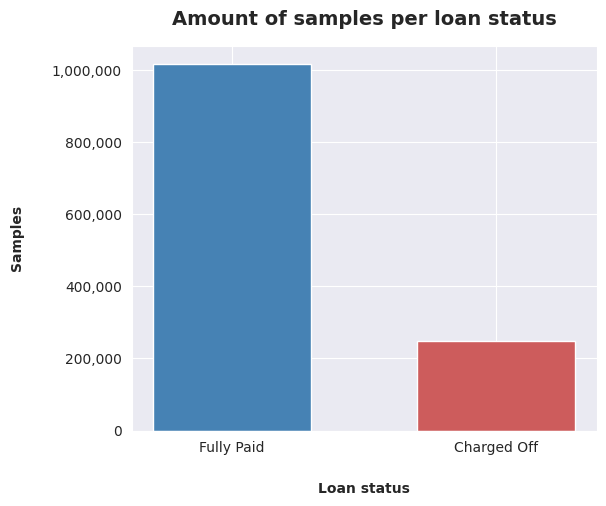

In [24]:
import matplotlib.ticker as mtick

sns.set_style("darkgrid")

x_vals = list(df_accepted['loan_status'].value_counts().index)
y_vals = list(df_accepted['loan_status'].value_counts().values)

colors = ['steelblue' if status == 0 else 'indianred' for status in range(len(y_vals))]

fig, ax = plt.subplots(figsize=(6, 5))

ax.bar(x_vals, y_vals, color=colors, width=0.6)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

ax.set_title("Amount of samples per loan status", pad=15, fontsize=14, fontweight="bold");
ax.set_xlabel("Loan status", labelpad=20, fontweight="bold");
ax.set_ylabel("Samples", labelpad=20, fontweight="bold");

* In general we have a good amount of data, we have a problem with imbalance classes, Fully Paid having 4x samples if compared to Charged Off, something we need to take care when evaluating the model. Metrics like "accuracy" are not enough due to the imbalance problem.

## Grade by Loan Status

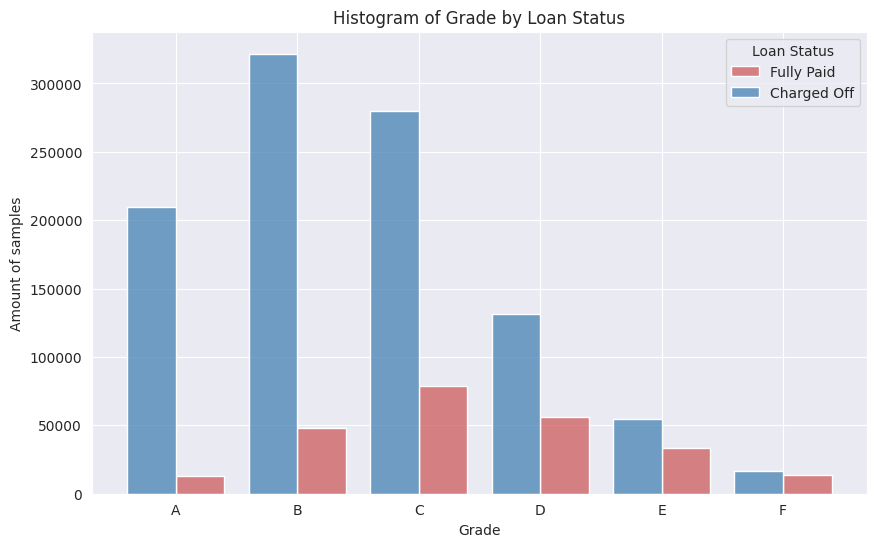

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order for grades
grade_order = ["A", "B", "C", "D", "E", "F"]

# Convert grade column to a categorical type with a specified order
df_accepted['grade'] = pd.Categorical(df_accepted['grade'], categories=grade_order, ordered=True)

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot histogram for grade with different colors based on loan_status
sns.histplot(data=df_accepted, x='grade', hue='loan_status', multiple='dodge',
             palette={'Fully Paid': 'steelblue', 'Charged Off': 'indianred'}, shrink=0.8)

# Add titles & labels
plt.title("Histogram of Grade by Loan Status")
plt.xlabel("Grade")
plt.ylabel("Amount of samples")
plt.legend(title='Loan Status', labels=['Fully Paid', 'Charged Off'])
plt.show()


The histogram of grade by loan status shows exactly that the riskier the loan was classified, there is more chances to default. If we look at grade 'A', a small percentage of the assigned risk was charged off, which is different from 'F', the riskier grade, which charged off represents almost 50% of the loans.

## Employment length by Loan Status

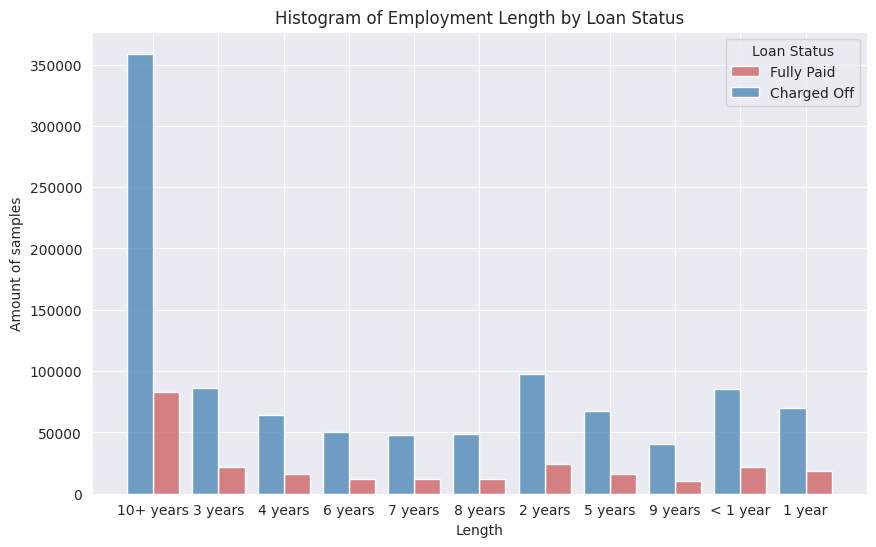

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot histogram for grade with different colors based on loan_status
sns.histplot(data=df_accepted, x='emp_length', hue='loan_status', multiple='dodge',
             palette={'Fully Paid': 'steelblue', 'Charged Off': 'indianred'}, shrink=0.8)

# Add titles & labels
plt.title("Histogram of Employment Length by Loan Status")
plt.xlabel("Length")
plt.ylabel("Amount of samples")
plt.legend(title='Loan Status', labels=['Fully Paid', 'Charged Off'])
plt.show()


Employment length of < 1 year default represents 20.53% of the values, while employment length of 10+ years default represents 18.78%. It is a small diference, so we'll remove this variable.

In [27]:
df_accepted.drop("emp_length", inplace=True, axis=1)

## Correlations

In [28]:
df_accepted_copy = df_accepted.copy()
df_accepted_copy['loan_status'] = df_accepted_copy['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

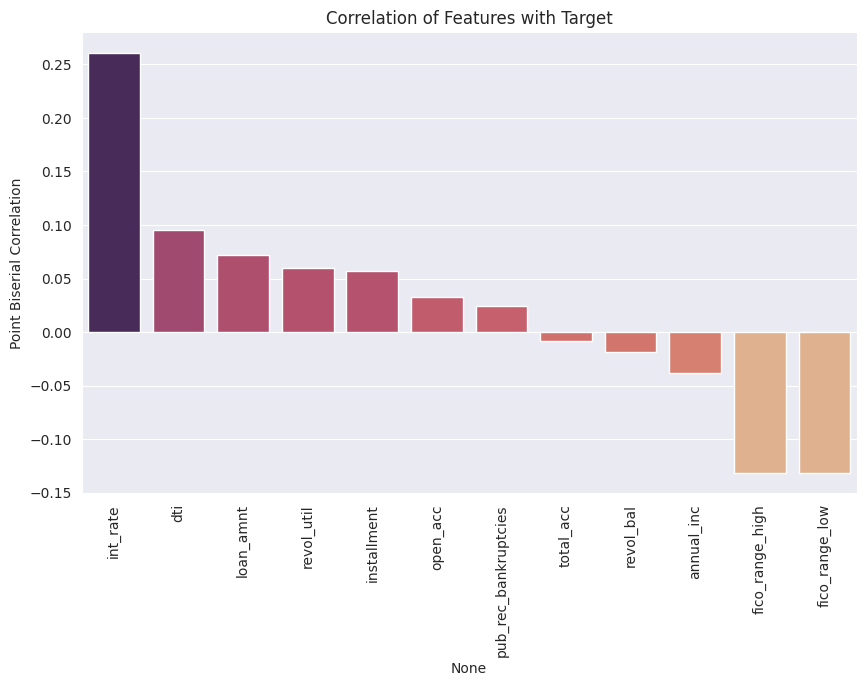

In [29]:
from scipy.stats import pointbiserialr

correlations = {}
for col in df_accepted_copy.select_dtypes(include=['number']).columns:
    if col != 'loan_status':
      corr, _ = pointbiserialr(df_accepted_copy[col], df_accepted_copy['loan_status'])
      correlations[col] = corr

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_df.index, y=corr_df['Correlation'], hue=corr_df['Correlation'], palette="flare", legend=False);
plt.xticks(rotation=90);
plt.title("Correlation of Features with Target");
plt.ylabel("Features");
plt.ylabel("Point Biserial Correlation");
plt.show();

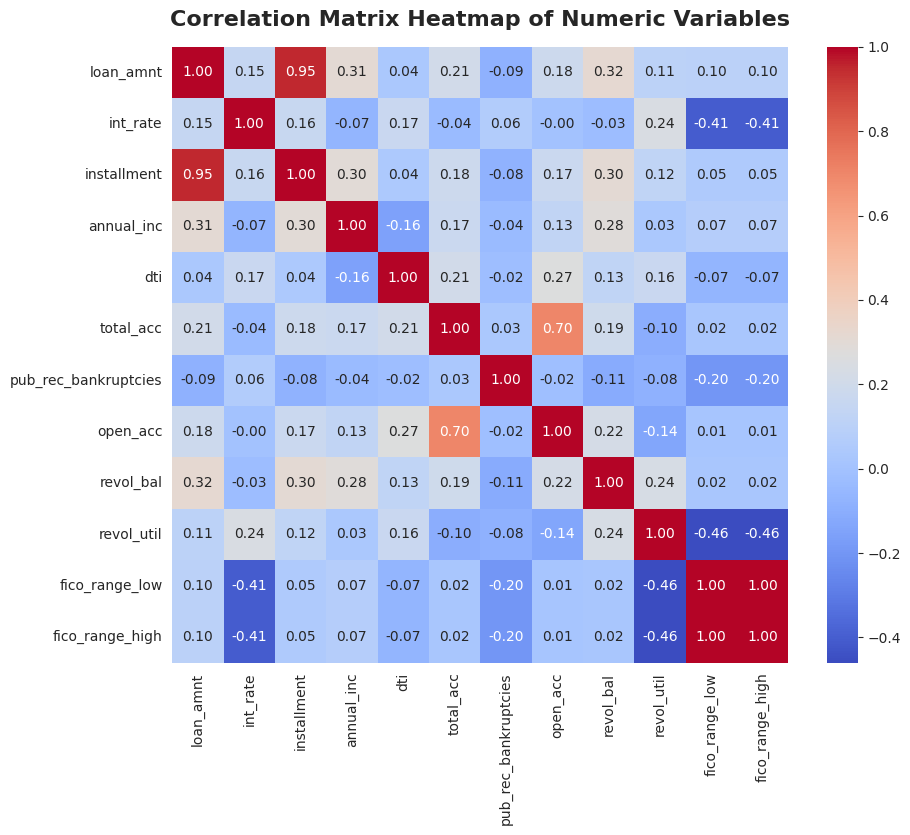

In [30]:
numeric_df = df_accepted.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric variables only
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

# Titles and labels
plt.title("Correlation Matrix Heatmap of Numeric Variables", fontsize=16, fontweight="bold", pad=15)
plt.show()

**loan_amnt & installment** are super high correlated with each other due to the higher the loan_amnt, higher is the installment, one of them must be removed from data. It can confuses our model with multicollinearity and most important, make it harder to interpret the model's decisions, which is something important in risk prediction.

**open_acc & total_acc** are also high correlated but moderate, they look like each other but provides different informations. If a person has open_acc and total_acc high, it can indicate a good history of credit, but if the total_acc is high and open_acc is low, it can indicate a bad history. Based on this analysis, we must keep it both variables, they are important if we look both.


In [31]:
df_accepted.drop("installment", inplace=True, axis=1)

## Home Ownership by Loan Status

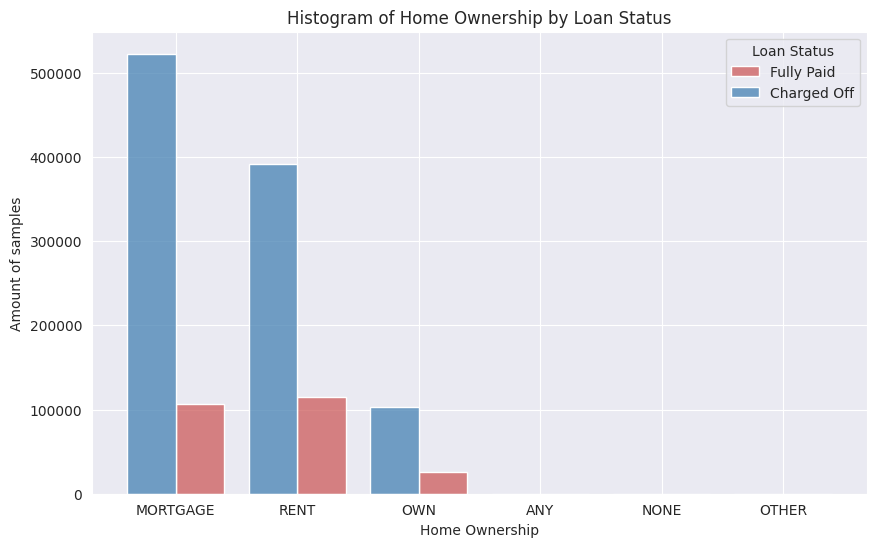

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot histogram for grade with different colors based on loan_status
sns.histplot(data=df_accepted, x='home_ownership', hue='loan_status', multiple='dodge',
             palette={'Fully Paid': 'steelblue', 'Charged Off': 'indianred'}, shrink=0.8)

# Add titles & labels
plt.title("Histogram of Home Ownership by Loan Status")
plt.xlabel("Home Ownership")
plt.ylabel("Amount of samples")
plt.legend(title='Loan Status', labels=['Fully Paid', 'Charged Off'])
plt.show()

Renters have the highest charged off rate, around 22.82%, followed by homeowners with 19.89% and mortgage holders 16.88%. It may suggest that borrowers who rent have less financial stability, the feature can be important for our model.

## Loan Amount by Loan Status

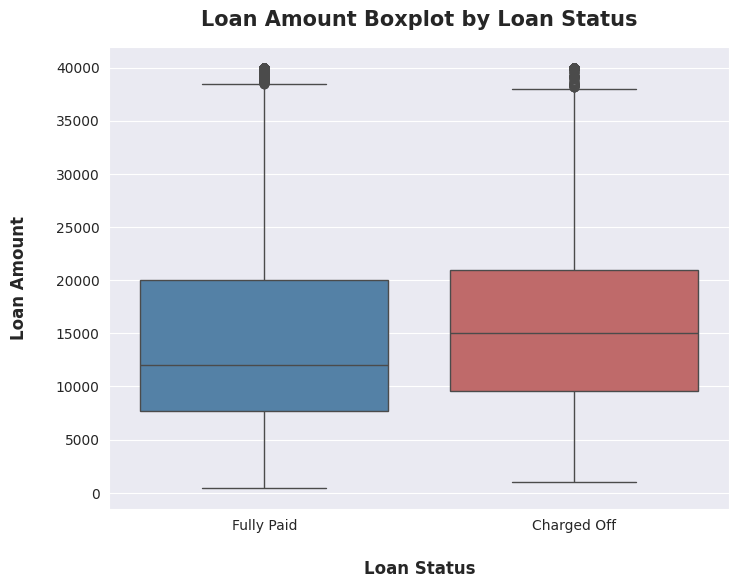

In [33]:
plt.figure(figsize=(8, 6))
colors = {'Fully Paid': 'steelblue', 'Charged Off': 'indianred'}

sns.boxplot(x=df_accepted['loan_status'], y=df_accepted['loan_amnt'], hue=df_accepted['loan_status'], palette=colors);

plt.title("Loan Amount Boxplot by Loan Status", pad=15, fontsize=15, fontweight="bold");
plt.xlabel("Loan Status", fontsize=12, fontweight="bold", labelpad=20);
plt.ylabel("Loan Amount", fontsize=12, fontweight="bold", labelpad=20);


* The spread of loan amount for both Fully Paid and Charged off are similar, with the median of default loans being a little higher, it suggests that the feature alone cannot be enough to classify the Loan Status.

## Annual Income by Loan Status

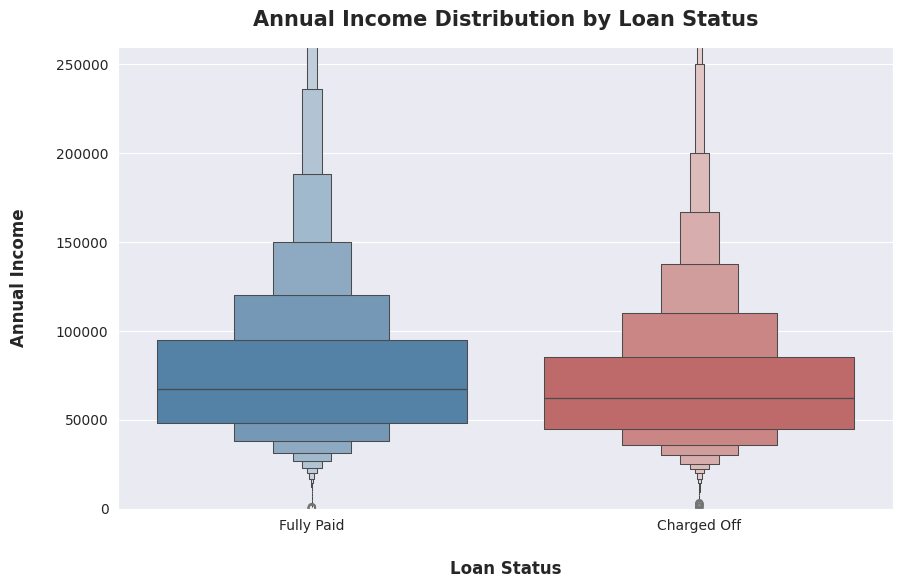

In [34]:
plt.figure(figsize=(10, 6))
colors = {'Fully Paid': 'steelblue', 'Charged Off': 'indianred'}

sns.boxenplot(x=df_accepted['loan_status'], y=df_accepted['annual_inc'], hue=df_accepted['loan_status'], palette=colors)

# Add titles and labels
plt.title("Annual Income Distribution by Loan Status", pad=15, fontsize=15, fontweight="bold")
plt.xlabel("Loan Status", fontsize=12, fontweight="bold", labelpad=20)
plt.ylabel("Annual Income", fontsize=12, fontweight="bold", labelpad=20)
plt.ylim(0, df_accepted['annual_inc'].quantile(0.99))
plt.show()


Boxen Plot is similar to boxplot, but the boxen provides a different quantile of the data in each box, withing the middle being the 50% of the data.

* The middle box around de IQR is similar for both fully paid and charged off people. Suggesting that this variable annual income alone does not provide a clear picture that differentiate fully paid and charged off.
* The mean of charged off is slightly lower than Fully Paid loans.
* The plot suggests that higher income borrowers are more likely to repay their loans, as we can see a higher concentration of Fully Paid for higher income.

## Interest rate by Loan Status

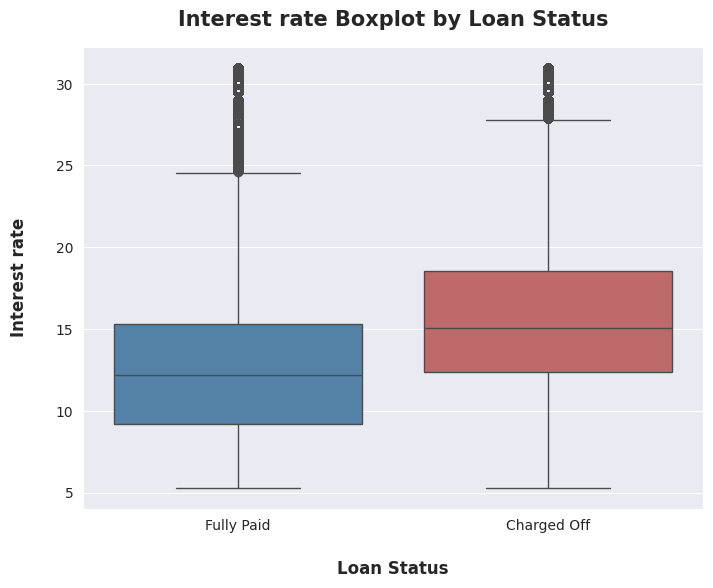

In [35]:
plt.figure(figsize=(8, 6))
colors = {'Fully Paid': 'steelblue', 'Charged Off': 'indianred'}

sns.boxplot(x=df_accepted['loan_status'], y=df_accepted['int_rate'], hue=df_accepted['loan_status'], palette=colors);

plt.title("Interest rate Boxplot by Loan Status", pad=15, fontsize=15, fontweight="bold");
plt.xlabel("Loan Status", fontsize=12, fontweight="bold", labelpad=20);
plt.ylabel("Interest rate", fontsize=12, fontweight="bold", labelpad=20);

* Interest rate is closely related to loan status. Loans with higher interest rates are more likely to end up as charged off. The spread and median for loans that were not fully paid is higher, gives insight that is a important variable.



In [36]:
from sklearn.feature_selection import mutual_info_classif

X = df_accepted[['grade', 'sub_grade']].apply(lambda x: x.astype('category').cat.codes)
y = df_accepted['loan_status']

mi_scores = mutual_info_classif(X, y)
print(f"Mutual Information for grade: {mi_scores[0]}")
print(f"Mutual Information for sub_grade: {mi_scores[1]}")

Mutual Information for grade: 0.07122494299605564
Mutual Information for sub_grade: 0.045679481446012415


Grade and sub grade are correlated in a certain way, because sub grade is a deeper information of grade. The problem with sub grade is that increases dimensionality for our data. Based on our tests with Mutual Information (measure how much info each feature provides about the target), grade has a slightly larger value than sub grade, having less classes, so we'll drop sub grade.

In [37]:
df_accepted.drop("sub_grade", axis=1, inplace=True)

# Feature Engineering

In [38]:
# Visualize columns that are not numeric
df_accepted.select_dtypes(include=['object'])

,term,home_ownership,verification_status,loan_status,zip_code,addr_state,purpose,initial_list_status,application_type
0,36 months,MORTGAGE,Not Verified,Fully Paid,190xx,PA,debt_consolidation,w,Individual
1,36 months,MORTGAGE,Not Verified,Fully Paid,577xx,SD,small_business,w,Individual
2,60 months,MORTGAGE,Not Verified,Fully Paid,605xx,IL,home_improvement,w,Joint App
4,60 months,MORTGAGE,Source Verified,Fully Paid,174xx,PA,major_purchase,w,Individual
5,36 months,RENT,Source Verified,Fully Paid,300xx,GA,debt_consolidation,w,Individual
...,...,...,...,...,...,...,...,...,...
2260688,60 months,OWN,Not Verified,Fully Paid,775xx,TX,home_improvement,f,Individual
2260690,60 months,MORTGAGE,Not Verified,Fully Paid,900xx,CA,debt_consolidation,f,Individual
2260691,60 months,MORTGAGE,Source Verified,Charged Off,863xx,AZ,home_improvement,f,Individual
2260692,60 months,RENT,Not Verified,Fully Paid,284xx,NC,medical,f,Individual


In [40]:
df_accepted['fico_score'] = (df_accepted['fico_range_low'] + df_accepted['fico_range_high']) / 2
df_accepted.drop(["fico_range_low", "fico_range_high"], inplace=True, axis=1)

In [41]:
# We'll drop zip code because is too many features to be one hot encoded
df_accepted.drop("zip_code", inplace=True, axis=1)

In [42]:
# Convert term to numeric (int) column
df_accepted['term'] = df_accepted['term'].apply(lambda x: int(x.split()[0]))

In [44]:
# Transform states into regions to reduce the amount of features
regions = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

df_accepted['region'] = df_accepted['addr_state'].map(
    {state: region for region, states in regions.items() for state in states}
)

df_accepted.drop("addr_state", inplace=True, axis=1)

In [46]:
# One-hot encode features
df_accepted = pd.get_dummies(df_accepted, columns=['verification_status', 'purpose', 'home_ownership', 'initial_list_status', 'application_type',  'region'])
df_accepted.head()

,loan_amnt,term,int_rate,grade,annual_inc,loan_status,dti,total_acc,pub_rec_bankruptcies,open_acc,...,home_ownership_OWN,home_ownership_RENT,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,region_Midwest,region_Northeast,region_South,region_West
0,3600.0,36,13.99,C,55000.0,Fully Paid,5.91,13.0,0.0,7.0,...,False,False,False,True,True,False,False,True,False,False
1,24700.0,36,11.99,C,65000.0,Fully Paid,16.06,38.0,0.0,22.0,...,False,False,False,True,True,False,True,False,False,False
2,20000.0,60,10.78,B,63000.0,Fully Paid,10.78,18.0,0.0,6.0,...,False,False,False,True,False,True,True,False,False,False
4,10400.0,60,22.45,F,104433.0,Fully Paid,25.37,35.0,0.0,12.0,...,False,False,False,True,True,False,False,True,False,False
5,11950.0,36,13.44,C,34000.0,Fully Paid,10.20,6.0,0.0,5.0,...,False,True,False,True,True,False,False,False,True,False


In [47]:
# Label encode grade values (order is important, so we choose label encoding instead of one-hot encoding)
from sklearn.preprocessing import LabelEncoder

enc_grade = LabelEncoder()
df_accepted['grade_encoded'] = enc_grade.fit_transform(df_accepted['grade'])
df_accepted.drop("grade", axis=1, inplace=True)
df_accepted['grade_encoded'].value_counts()

,count
grade_encoded,
1,369637
2,358529
0,222190
3,187747
4,88160
5,30347
6,8668


In [48]:
# Remove outliers 3 std from the mean
from scipy import stats

numeric_columns = df_accepted.select_dtypes(include=['number']).columns
df_cleaned = df_accepted[(np.abs(stats.zscore(df_accepted[numeric_columns])) < 3).all(axis=1)]

In [49]:
df_cleaned['loan_status'].value_counts()

,count
loan_status,
Fully Paid,950185
Charged Off,228847


In [50]:
df_accepted['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1018136
Charged Off,247142


In [51]:
# Transform loan status into binary
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

<ipython-input-51-6ac3507fa494>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


# Normalize and split data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop("loan_status", axis=1), df_cleaned['loan_status'], test_size=0.25, random_state=42)

In [53]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models

In [55]:
# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier()
}

# Run and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"{name}: Accuracy = {accuracy:.2f}")
    print(f"{name}: f1 score = {f1}")

Logistic Regression: Accuracy = 0.81
Logistic Regression: f1 score = 0.5065227243101951
Random Forest: Accuracy = 0.81
Random Forest: f1 score = 0.5024089251532025
K-Nearest Neighbors: Accuracy = 0.78
K-Nearest Neighbors: f1 score = 0.5453550969244932
Decision Tree: Accuracy = 0.71
Decision Tree: f1 score = 0.5449541247312638
XGBoost: Accuracy = 0.81
XGBoost: f1 score = 0.511682682521113


In [56]:
from collections import Counter

class_counts = Counter(y_train)
majority_class = class_counts[0]
minority_class = class_counts[1]

class_imbalance_ratio = majority_class / minority_class
print("Class Imbalance Ratio:", class_imbalance_ratio)

Class Imbalance Ratio: 4.14978073623705


In [57]:
# Upsampling technique
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [62]:
xgb = XGBClassifier(scale_pos_weight=1.6, random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87    237622
           1       0.41      0.28      0.33     57136

    accuracy                           0.78    294758
   macro avg       0.62      0.59      0.60    294758
weighted avg       0.76      0.78      0.77    294758

0.7823434817714872
0.6012833326754548


# SHAP (SHapley Additive Explanations)

In [64]:
feature_labels = {
    'loan_amnt': "Loan Amount",
    'term': "Loan Term (in months)",
    'int_rate': "Interest Rate (%)",
    'annual_inc': "Annual Income",
    'loan_status': "Loan Status",
    'dti': "Debt-to-Income Ratio (%)",
    'total_acc': "Total Credit Accounts",
    'pub_rec_bankruptcies': "Public Record Bankruptcies",
    'open_acc': "Open Credit Accounts",
    'revol_bal': "Revolving Balance",
    'revol_util': "Revolving Utilization (%)",
    'fico_score': "FICO Credit Score",
    'verification_status_Not Verified': "Verification Status: Not Verified",
    'verification_status_Source Verified': "Verification Status: Source Verified",
    'verification_status_Verified': "Verification Status: Verified",
    'purpose_car': "Purpose: Car Purchase",
    'purpose_credit_card': "Purpose: Credit Card",
    'purpose_debt_consolidation': "Purpose: Debt Consolidation",
    'purpose_educational': "Purpose: Educational Expenses",
    'purpose_home_improvement': "Purpose: Home Improvement",
    'purpose_house': "Purpose: House Purchase",
    'purpose_major_purchase': "Purpose: Major Purchase",
    'purpose_medical': "Purpose: Medical Expenses",
    'purpose_moving': "Purpose: Moving Expenses",
    'purpose_other': "Purpose: Other",
    'purpose_renewable_energy': "Purpose: Renewable Energy",
    'purpose_small_business': "Purpose: Small Business",
    'purpose_vacation': "Purpose: Vacation",
    'purpose_wedding': "Purpose: Wedding",
    'home_ownership_ANY': "Home Ownership: Any",
    'home_ownership_MORTGAGE': "Home Ownership: Mortgage",
    'home_ownership_NONE': "Home Ownership: None",
    'home_ownership_OTHER': "Home Ownership: Other",
    'home_ownership_OWN': "Home Ownership: Own",
    'home_ownership_RENT': "Home Ownership: Rent",
    'initial_list_status_f': "Initial List Status: Fractional",
    'initial_list_status_w': "Initial List Status: Whole",
    'application_type_Individual': "Application Type: Individual",
    'application_type_Joint App': "Application Type: Joint Application",
    'region_Midwest': "Region: Midwest",
    'region_Northeast': "Region: Northeast",
    'region_South': "Region: South",
    'region_West': "Region: West",
    'grade_encoded': "Loan Grade (Encoded)"
}


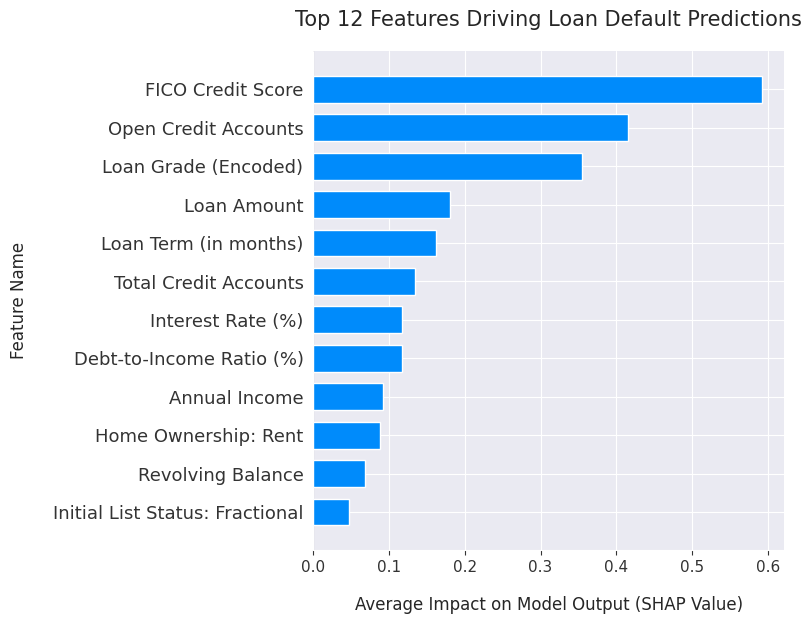

In [65]:
import shap

# Initialize SHAP TreeExplainer for your XGBoost model
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the scaled test data
shap_values = explainer.shap_values(X_test)

plt.gca().set_xlabel("")

# Visualize SHAP summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=[feature_labels.get(col, col) for col in df_cleaned.drop(columns=['loan_status']).columns.tolist()], max_display=12, show=False)

plt.gca().set_xlabel("Average Impact on Model Output (SHAP Value)", labelpad=15, fontsize=12)
plt.gca().set_ylabel("Feature Name", labelpad=18, fontsize=12)
plt.gca().set_title("Top 12 Features Driving Loan Default Predictions", pad=18, fontsize=15)

plt.show()

In [82]:
y_test.reset_index(drop=True, inplace=True)

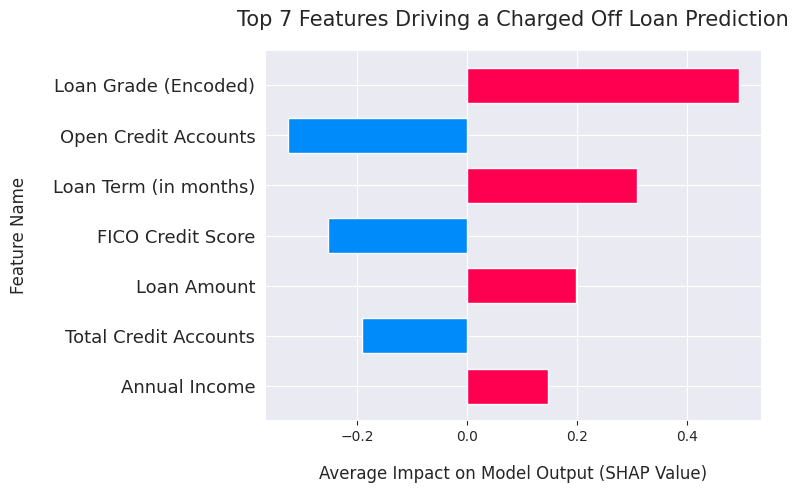

In [155]:
y_test_array = y_test.values

# Get predictions from the model
predictions = xgb.predict(X_test)

# Find indices of correctly classified "charged off" instances
charged_off_index = np.where((y_test_array == 1) & (predictions == 1))[0][13]

single_instance = X_test[charged_off_index].reshape(1, -1)

explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the scaled test data
shap_values = explainer.shap_values(single_instance)

plt.gca().set_xlabel("")

shap.bar_plot(
    shap_values[0],
    feature_names=[feature_labels.get(col, col) for col in df_cleaned.drop(columns=['loan_status']).columns.tolist()],
    show=False
)

plt.gca().set_xlabel("Average Impact on Model Output (SHAP Value)", labelpad=15, fontsize=12)
plt.gca().set_ylabel("Feature Name", labelpad=18, fontsize=12)
plt.gca().set_title("Top 7 Features Driving a Charged Off Loan Prediction", pad=18, fontsize=15)

plt.show()

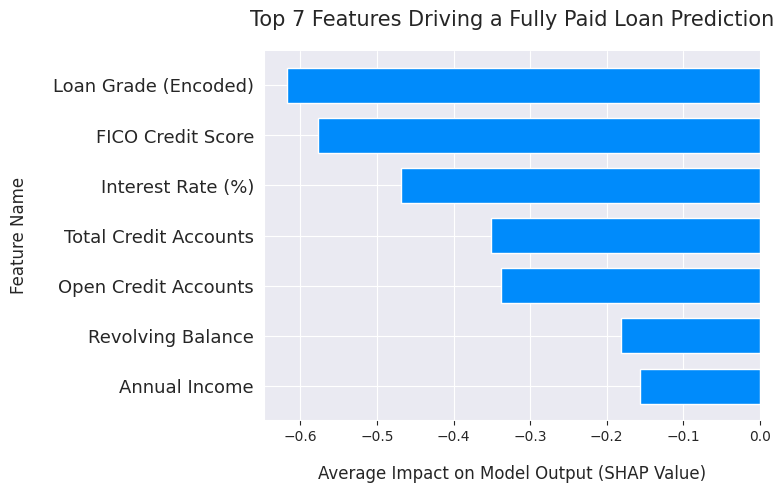

In [157]:
y_test_array = y_test.values

# Get predictions from the model
predictions = xgb.predict(X_test)

# Find indices of correctly classified "charged off" instances
fullypaid_index = np.where((y_test_array == 0) & (predictions == 0))[0][5]

single_instance = X_test[fullypaid_index].reshape(1, -1)

explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the scaled test data
shap_values = explainer.shap_values(single_instance)

plt.gca().set_xlabel("")

shap.bar_plot(
    shap_values[0],
    feature_names=[feature_labels.get(col, col) for col in df_cleaned.drop(columns=['loan_status']).columns.tolist()],
    show=False
)

plt.gca().set_xlabel("Average Impact on Model Output (SHAP Value)", labelpad=15, fontsize=12)
plt.gca().set_ylabel("Feature Name", labelpad=18, fontsize=12)
plt.gca().set_title("Top 7 Features Driving a Fully Paid Loan Prediction", pad=18, fontsize=15)

plt.show()